In [9]:
from art.utils import load_dataset
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import CarliniLInfMethod
from art.metrics import empirical_robustness


import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Loading hand writing dataset

In [10]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=10000):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [11]:
cifar10 = tf.keras.datasets.cifar10# Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = cifar10.load_data() # Load data

# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [12]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [13]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (20000, 32, 32, 3)
Lengh of dimensions for y_train:  (20000,)
Lengh of dimensions for x_test:  (4000, 32, 32, 3)
Lengh of dimensions for y_test:  (4000,)


In [14]:
'''reshape'''
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

In [15]:
'''Normalization'''
#x_train = x_train / 255.0
#y_train = y_train / 255.0

'Normalization'

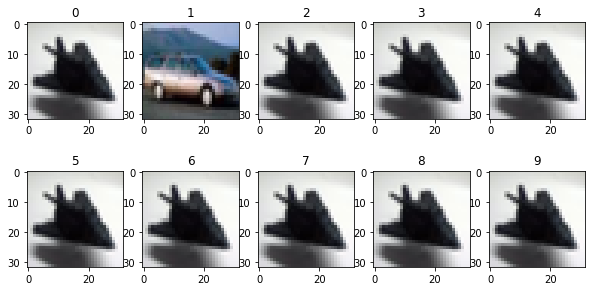

In [17]:
n_classes = 10
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])])
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [18]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_object,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 20)        560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 720)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               360500    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [19]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
625/625 [==============================] - 11s 17ms/step - loss: 0.5763 - accuracy: 0.6503 - val_loss: 0.4789 - val_accuracy: 0.7013
Epoch 2/5
625/625 [==============================] - 8s 12ms/step - loss: 0.4691 - accuracy: 0.7009 - val_loss: 0.5712 - val_accuracy: 0.7070
Epoch 3/5
625/625 [==============================] - 8s 13ms/step - loss: 0.4375 - accuracy: 0.7166 - val_loss: 0.6169 - val_accuracy: 0.7063
Epoch 4/5
625/625 [==============================] - 8s 12ms/step - loss: 0.4234 - accuracy: 0.7133 - val_loss: 0.4273 - val_accuracy: 0.7170
Epoch 5/5
625/625 [==============================] - 11s 18ms/step - loss: 0.4040 - accuracy: 0.7282 - val_loss: 0.4329 - val_accuracy: 0.7172


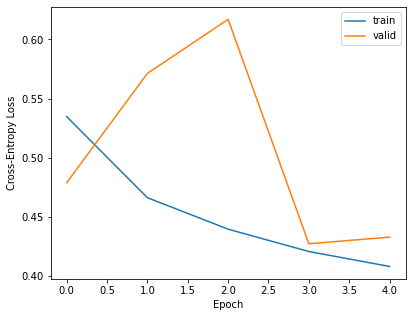

In [20]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.4f' % score[1])

Test cross-entropy loss: 0.43289
Test accuracy: 0.7172


# Carlini and Wagner linf

In [22]:
'''wrap the model an calculte emperical robustnees'''
classifier = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(32,32,3), clip_values=(0, 1),
                                   loss_object = loss_object)

In [23]:
eps_list=np.arange(0.1, 1, 0.1)

acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    adv_cw_model = CarliniLInfMethod(classifier, eps=eps_list[i], targeted=False)
    adv_cw_x = adv_cw_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_cw_x)
    acc[i]=classifier._model.evaluate(adv_cw_x, y_test)[1]
    print(eps_list[i])


125/125 [==============================] - 1s 4ms/step - loss: 1.0168 - accuracy: 0.4708
0.1



125/125 [==============================] - 1s 4ms/step - loss: 1.2229 - accuracy: 0.4420
0.2



125/125 [==============================] - 1s 4ms/step - loss: 1.3695 - accuracy: 0.4288
0.30000000000000004



125/125 [==============================] - 1s 5ms/step - loss: 1.3918 - accuracy: 0.4202
0.4



125/125 [==============================] - 1s 7ms/step - loss: 1.4485 - accuracy: 0.4153
0.5



125/125 [==============================] - 0s 4ms/step - loss: 1.5253 - accuracy: 0.4125
0.6



125/125 [==============================] - 1s 4ms/step - loss: 1.5176 - accuracy: 0.4108
0.7000000000000001



125/125 [==============================] - 0s 4ms/step - loss: 1.5252 - accuracy: 0.4103
0.8



125/125 [==============================] - 1s 4ms/step - loss: 1.5335 - accuracy: 0.4103
0.9


In [24]:
eps_list=np.arange(0.01, 0.05, 0.005)

acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    adv_cw_model = CarliniLInfMethod(classifier, eps=eps_list[i], targeted=False)
    adv_cw_x = adv_cw_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_cw_x)
    acc[i]=classifier._model.evaluate(adv_cw_x, y_test)[1]
    print(eps_list[i])


125/125 [==============================] - 1s 4ms/step - loss: 0.4689 - accuracy: 0.6378
0.01



125/125 [==============================] - 1s 4ms/step - loss: 0.5211 - accuracy: 0.5897
0.015



125/125 [==============================] - 1s 6ms/step - loss: 0.5710 - accuracy: 0.5638
0.019999999999999997



125/125 [==============================] - 1s 10ms/step - loss: 0.6165 - accuracy: 0.5483
0.024999999999999998



125/125 [==============================] - 1s 6ms/step - loss: 0.6506 - accuracy: 0.5365
0.03



125/125 [==============================] - 1s 4ms/step - loss: 0.6811 - accuracy: 0.5255
0.034999999999999996



125/125 [==============================] - 1s 4ms/step - loss: 0.7222 - accuracy: 0.5185
0.039999999999999994



125/125 [==============================] - 1s 4ms/step - loss: 0.7457 - accuracy: 0.5117
0.045


In [25]:
adv_cw_model = CarliniLInfMethod(classifier, eps=0.05, targeted=False)
adv_cw_x = adv_cw_model.generate(x=x_test)
prediction_x = classifier.predict(x=adv_cw_x)
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_cw_x, y_test)[1])


accuracy on adversarial examples:
125/125 [==============================] - 1s 4ms/step - loss: 0.7961 - accuracy: 0.5038
0.5037500262260437


# ---------------------------------------------------

In [ ]:
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_pgd_x, y_test)[1])

In [ ]:
'''Score on adversarial examples'''
score = model.evaluate(adv_pgd_x, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_pgd_x[0])  
plt.show()